# Aplicación
Pequeña aplicación para insertar una imagen por la red y obtener sus características. Si la imagen se toma del dataset, podrá ver su etiqueta para comprobar su exactitud.

Ejecute el bloque a continuación para tener la configuración base.

In [170]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import skopt
from skopt import callbacks
from skopt import dump, load
from skopt.callbacks import CheckpointSaver
import math
import PIL
import pandas as pd
import os
import time
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim import lr_scheduler
from PIL import Image
from enum import Enum
from livelossplot import PlotLosses
import sys
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

class Mode(Enum):
    GENERAL = 0  #Modelo no vgg modificable por el usuario
    VGG = 1      #Uso único de la clasificación de VGG
    MIDVGG3 = 2  #Uso único de fine-tunning de 3 capas de VGG
    BLANKVGG = 3 #Red con estructura VGG normal
    MIDVGG2 = 4  #Uso único de fine-tunning de 2 capas de VGG
    MIDVGG1 = 5  #Uso único de fine-tunning de 1 capa de VGG

MODE = Mode.VGG

# Generador de modelos de red
def getClassifier(intro,outro,netArray,d_dropout=0.5):
    if(len(netArray) < 1): 
        return []
    newClassifier = [nn.Linear(intro, netArray[0]),nn.Dropout(p=d_dropout, inplace=False),nn.ReLU(inplace=True)]
    for i in range(len(netArray)):
        if(i == 0):
            continue
        else:  
            newClassifier = newClassifier + [nn.Linear(netArray[i-1], netArray[i]),nn.Dropout(p=d_dropout, inplace=False),nn.ReLU(inplace=True)]
    newClassifier = newClassifier + [nn.Linear(netArray[len(netArray) - 1], outro)]
    return newClassifier        
    
class GeneralModel (nn.Module):
    def __init__(self,classes):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        #30x30x6
        self.pool1 = nn.MaxPool2d(2,2)
        #15x15x6
        self.conv2 = nn.Conv2d(6,16,2)
        #14x14x16
        self.conv3 = nn.Conv2d(16,32,5)
        #10x10x16
        self.fc1 = nn.Linear(32*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,classes)

    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = x.view(-1,32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGGModel (nn.Module):
    def __init__(self,net,dropout,netArray,classes):
        super(VGGModel,self).__init__()
        self.features = net.features
        for param in self.features.parameters():
            param.require_grad = False
        nFeats = net.classifier[6].in_features
        feats = list(net.classifier.children())[:-7]
        nFeats = net.classifier[0].in_features
        feats.extend(getClassifier(nFeats,classes,netArray,dropout))
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(*feats)
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x    

class MidVGG3Model (nn.Module):
    def __init__(self,net):
        super(MidVGG3Model,self).__init__()
        self.features = net.features[:-10]
        self.newFeatures = net.features[-10:]
        for param in self.newFeatures.parameters():
            param.require_grad = True
        self.avgpool = net.avgpool
        self.classifier = net.classifier
    def forward(self,x):
        x = self.features(x)
        x = self.newFeatures(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class MidVGG2Model (nn.Module):
    def __init__(self,net):
        super(MidVGG2Model,self).__init__()
        self.features = net.features[:-7]
        self.newFeatures = net.features[-7:]
        for param in self.newFeatures.parameters():
            param.require_grad = True
        self.avgpool = net.avgpool
        self.classifier = net.classifier
    def forward(self,x):
        x = self.features(x)
        x = self.newFeatures(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class MidVGG1Model (nn.Module):
    def __init__(self,net):
        super(MidVGG1Model,self).__init__()
        self.features = net.features[:-4]
        self.newFeatures = net.features[-4:]
        for param in self.newFeatures.parameters():
            param.require_grad = True
        self.avgpool = net.avgpool
        self.classifier = net.classifier
    def forward(self,x):
        x = self.features(x)
        x = self.newFeatures(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
def generateModel(MODE,dropout,netArray,classes):
    newModel = None
    print(MODE)
    if(MODE == Mode.GENERAL):
        newModel = GeneralModel(classes)
        return newModel
    if(MODE == Mode.VGG):
        newModel = models.vgg16_bn(pretrained=True)
        newModel = VGGModel(newModel,dropout,netArray,classes)
        return newModel
    if(MODE == Mode.BLANKVGG):
        newModel = models.vgg16_bn(pretrained=True)
        feats = list(newModel.classifier.children())[:-1]
        feats.extend([nn.Linear(4096, classes)])
        newModel.classifier = nn.Sequential(*feats)
        return newModel
    if(MODE == Mode.MIDVGG3):
        newModel = models.vgg16_bn(pretrained=True)
        MODE = Mode.VGG
        newModel = MidVGG3Model(generateModel(MODE,dropout,netArray,classes))
        MODE = Mode.MIDVGG3
        return newModel
    if(MODE == Mode.MIDVGG2):
        newModel = models.vgg16_bn(pretrained=True)
        MODE = Mode.VGG
        newModel = MidVGG2Model(generateModel(MODE,dropout,netArray,classes))
        MODE = Mode.MIDVGG2
        return newModel
    if(MODE == Mode.MIDVGG1):
        newModel = models.vgg16_bn(pretrained=True)
        MODE = Mode.VGG
        newModel = MidVGG1Model(generateModel(MODE,dropout,netArray,classes))
        MODE = Mode.MIDVGG1
        return newModel
    return newModel
    
def createModel(MODE=Mode.GENERAL,dropout=0.5,netArray=[4096,4096],classes=7):
    newModel = generateModel(MODE,dropout,netArray,classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    newModel.to(device)
    newModel.cuda()
    return newModel


# Transformaciones
img_width, img_height, _ = 32, 32, 3
image_size = (img_width, img_height)
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
mean = [0.8553, 0.8376, 0.8319] 
std = [0.2711, 0.2837, 0.2879] 
vggTransform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# Clases del dataset
classes = [["Apparel", "Accessories", "Footwear", "Personal Care", "Free Items", "Sporting Goods", "Home"],
            ['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts', 'Flip Flops', 'Bags', 'Innerwear',
               'Sandal', 'Shoe Accessories', 'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
               'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets', 'Apparel Set', 'Headwear', 'Mufflers',
               'Skin Care', 'Makeup', 'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories', 'Water Bottle',
               'Eyes', 'Bath and Body', 'Gloves', 'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles', 'Hair',
               'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands', 'Vouchers'],
            ['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks', 'Casual Shoes', 'Belts', 
                'Flip Flops', 'Handbags', 'Tops', 'Bra', 'Sandals', 'Shoe Accessories', 'Sweatshirts', 
                'Deodorant', 'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas', 'Waistcoat', 'Sports Shoes', 'Shorts', 
                'Briefs', 'Sarees', 'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests', 'Pendant', 'Nail Polish', 
                'Laptop Bag', 'Scarves', 'Rain Jacket', 'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring', 'Kurta Sets', 
                'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers', 'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta', 'Capris', 
                'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics', 'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser', 'Necklace and Chains', 
                'Duffel Bag', 'Sports Sandals', 'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag', 'Tracksuits', 'Swimwear', 'Shoe Laces', 
                'Fragrance Gift Set', 'Bangle', 'Nightdress', 'Ties', 'Baby Dolls', 'Leggings', 'Highlighter and Blush', 'Travel Accessory', 'Kurtis', 'Mobile Pouch', 
                'Messenger Bag', 'Lip Care', 'Face Moisturisers', 'Compact', 'Eye Cream', 'Accessory Gift Set', 'Beauty Accessory', 'Jumpsuit', 'Kajal and Eyeliner', 
                'Water Bottle', 'Suspenders', 'Lip Liner', 'Robe', 'Salwar and Dupatta', 'Patiala', 'Stockings', 'Eyeshadow', 'Headband', 'Tights', 'Nail Essentials', 
                'Churidar', 'Lounge Tshirts', 'Face Scrub and Exfoliator', 'Lounge Shorts', 'Gloves', 'Mask and Peel', 'Wristbands', 'Tablet Sleeve', 'Ties and Cufflinks', 
                'Footballs', 'Stoles', 'Shapewear', 'Nehru Jackets', 'Salwar', 'Cufflinks', 'Jeggings', 'Hair Colour', 'Concealer', 'Rompers', 'Body Lotion', 'Sunscreen', 
                'Booties', 'Waist Pouch', 'Hair Accessory', 'Rucksacks', 'Basketballs', 'Lehenga Choli', 'Clothing Set', 'Mascara', 'Toner', 'Cushion Covers', 'Key chain', 
                'Makeup Remover', 'Lip Plumper', 'Umbrellas', 'Face Serum and Gel', 'Hat', 'Mens Grooming Kit', 'Rain Trousers', 'Body Wash and Scrub', 'Suits', 'Ipad'],
           ['Navy Blue','Blue','Silver','Black','Grey','Green','Purple','White','Beige','Brown','Bronze','Teal','Copper','Pink','Off White','Maroon','Red','Khaki','Orange',
            'Coffee Brown','Yellow','Charcoal','Gold','Steel','Tan','Multi','Magenta','Lavender','Sea Green','Cream','Peach','Olive','Skin','Burgundy','Grey Melange','Rust',
            'Rose','Lime Green','Mauve','Turquoise Blue','Metallic','Mustard','Taupe','Nude','Mushroom Brown','nan','Fluorescent Green'],
           ['Men', 'Women', 'Boys', 'Girls', 'Unisex'],
           ['Fall', 'Summer', 'Winter', 'Spring', 'nan'],
           ['Casual', 'Ethnic', 'Formal', 'Sports', 'nan', 'Smart Casual', 'Travel', 'Party', 'Home']
          ]

# Código de carga de la imagen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def vggImageLoader(image_name):
    image = Image.open(image_name)
    image = vggTransform(image)
    image = torch.tensor([image.tolist()])
    return image.cuda()  

 ## Carga de redes
 En caso de querer usar otro modelo, inserte los parámetros correspondientes al número de neuronas y el modelo a cargar. Recuerde que red y modelo guardado deben tener la misma configuración para combinarse.

In [171]:
# Modifique esta sección para modificar MasterCategory
redMasterCategory = createModel(Mode.MIDVGG3,0,[512,8192],len(classes[0]))
redMasterCategory.load_state_dict(torch.load("./DaBestAccMasterCategory"))
redMasterCategory.eval()

# Modifique esta sección para modificar SubCategory
redSubCategory = createModel(Mode.MIDVGG3,0,[1024,512],len(classes[1]))
redSubCategory.load_state_dict(torch.load("./DaBestAccSubCategory"))
redSubCategory.eval()

# Modifique esta sección para modificar ArticleType
redArticleType = createModel(Mode.MIDVGG3,0,[1024,4096],len(classes[2]))
redArticleType.load_state_dict(torch.load("./DaBestAccArticleType"))
redArticleType.eval()

# Modifique esta sección para modificar BaseColour
redBaseColour = createModel(Mode.MIDVGG3,0,[512,4096],len(classes[3]))
redBaseColour.load_state_dict(torch.load("./DaBestAccBaseColour"))
redBaseColour.eval()

# Modifique esta sección para modificar Gender
redGender = createModel(Mode.MIDVGG3,0,[8192,512],len(classes[4]))
redGender.load_state_dict(torch.load("./DaBestAccGender"))
redGender.eval();

# Modifique esta sección para modificar Season
redSeason = createModel(Mode.MIDVGG3,0,[4096,4096],len(classes[5]))
redSeason.load_state_dict(torch.load("./BESTSEASONMIDVGG3_20"))
redSeason.eval();

## Modifique esta sección para modificar Usage
redUsage = createModel(Mode.MIDVGG3,0,[512,2048],len(classes[6]))
redUsage.load_state_dict(torch.load("./DaBestAccUsage"))
redUsage.eval();


#########################
#Código de procesamiento de imágenes
def getMasterCategory(image):
    image = vggImageLoader(image)
    results = redMasterCategory(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[0][predicted]

def getSubCategory(image):
    image = vggImageLoader(image)
    results = redSubCategory(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[1][predicted]

def getArticleType(image):
    image = vggImageLoader(image)
    results = redArticleType(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[2][predicted]

def getBaseColour(image):
    image = vggImageLoader(image)
    results = redBaseColour(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[3][predicted]

def getGender(image):
    image = vggImageLoader(image)
    results = redGender(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[4][predicted]

def getSeason(image):
    image = vggImageLoader(image)
    results = redSeason(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[5][predicted]

def getUsage(image):
    image = vggImageLoader(image)
    results = redUsage(image)
    predicted = torch.max(results,1)
    predicted = predicted.indices.item()
    return classes[6][predicted]

def getResults(image):
    print(getMasterCategory(image),
        getSubCategory(image),
        getArticleType(image),
        getBaseColour(image),
        getGender(image),
        getSeason(image),
        getUsage(image))
    return [
        getMasterCategory(image),
        getSubCategory(image),
        getArticleType(image),
        '',
        getGender(image),
        getSeason(image),
        getUsage(image)
    ]



Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0
Mode.MIDVGG3
Mode.VGG
cuda:0


#### Obtención de las etiquetas del dataset

In [166]:
path= "/storage/datasets/fashion-dataset/" 
file_list = pd.read_csv(path + "styles.csv", error_bad_lines=False);

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

## Procesamiento de imagen de dataset

Ponga a continuación el ID de la imagen del dataset de la cual quiere obtener sus características

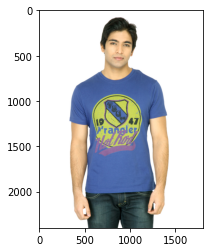

In [191]:
##Introduzca el id aquí##
idObjetivo = 20255
#########################
pil_im = Image.open('/storage/datasets/fashion-dataset/images/'+ str(idObjetivo) +'.jpg'); 
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

### Predicción

In [192]:
print("Predicción")
getResults('/storage/datasets/fashion-dataset/images/'+ str(idObjetivo) +'.jpg');


Predicción
Apparel Topwear Tshirts Blue Men Fall Casual


### Etiquetas reales 

In [193]:
a = file_list.loc[file_list['id'] == idObjetivo]
print("Etiqueta")
print(a.get('masterCategory').values.item(), a.get('subCategory').values.item(),a.get('articleType').values.item(),
      a.get('baseColour').values.item(),a.get('gender').values.item(),a.get('season').values.item(),a.get('usage').values.item())

Etiqueta
Apparel Topwear Tshirts Blue Men Fall Casual




## Procesamiento de imagen propia

Introduzca a continuación la dirección del la imagen a abrir

In [194]:
path = ""

In [ ]:
pil_im = Image.open(path); 
im_array = np.asarray(pil_im)
plt.imshow(im_array)
plt.show()

print("Predicción")
getResults('/storage/datasets/fashion-dataset/images/'+ str(idObjetivo) +'.jpg');